### Load built-in Python libraries

In [1]:
from   datetime import date, datetime
from   time     import sleep, time, monotonic
import math

### Load pandas and matplotlib

In [2]:
import pandas             as pd
import matplotlib.pyplot  as plt
from   IPython.display    import display

### Load Qiskit libraries and related functions

In [3]:
# Load Qiskit libraries and related functions
try:
    import qiskit
    import qiskit.quantum_info          as     qi
    from   qiskit                       import QuantumRegister, ClassicalRegister, transpile
    from   qiskit.circuit               import Parameter, ParameterVector, QuantumCircuit
    from   qiskit.circuit.library       import RGQFTMultiplier, CU1Gate
    from   qiskit.primitives            import Estimator # Sampler
    try:
        from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_distribution
    except:
        from qiskit.visualization       import circuit_drawer, plot_histogram, plot_distribution

    print(qiskit.__version__)
    
except Exception as err:
    print(err)

1.1.0


### Load Qiskit AER libraries and related functions

In [4]:
# Load Qiskit AER libraries and related functions
aer           = None
aer_estimator = None

try:
    import qiskit_aer
    from   qiskit_aer            import AerSimulator
    from   qiskit_aer.primitives import Estimator
    
    aer           = AerSimulator()
    aer_estimator = Estimator()
    
    print(qiskit_aer.__version__)

except Exception as err:
    print(err)

0.14.2


### Load Qiskit Runtime libraries and related functions

In [5]:
# Load Qiskit Runtime libraries and related functions
channel      = "ibm_quantum"
backend_name = "ibm_brisbane" # "ibm_ sherbrooke" , "ibm_ osaka" , "ibm_ kyoto"
service           = None
real_backend      = None
real_pass_manager = None

try:
    import qiskit_ibm_runtime
    from qiskit_ibm_runtime                    import QiskitRuntimeService, EstimatorOptions, Sampler, SamplerV2, EstimatorV2 as Estimator
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.fake_provider      import FakeBrisbane, FakeKyoto, FakeOsaka # FakeSingaporeV2

    try:
        service = QiskitRuntimeService( channel=channel )
        # service.delete_account( channel=channel ) # switch account
        
        real_backend = service.backend( backend_name ) 
        real_pass_manager = generate_preset_pass_manager( optimization_level=3, backend=real_backend )
        print("Existing IBM quantum account found and loaded.")

    except Exception as err:

        try:
            f = open("../Account/API.token2","r")
            APITOKEN = f.readline()
            
            print("Loading new IBM quantum account...")
            service = QiskitRuntimeService(   channel=channel, token=APITOKEN )
            QiskitRuntimeService.save_account(channel=channel, token=APITOKEN )
            print("IBM quantum account saved to notebook environment.")

            real_backend = service.backend( name = backend_name )
            real_pass_manager = generate_preset_pass_manager( optimization_level=1, backend=real_backend )

        except:
            try:
                f = open("./Account/API.token2","r")
                APITOKEN = f.readline()
                
                print("Loading new IBM quantum account...")
                service = QiskitRuntimeService(   channel=channel, token=APITOKEN )
                QiskitRuntimeService.save_account(channel=channel, token=APITOKEN )
                print("IBM quantum account saved to notebook environment.")
    
                real_backend = service.backend( name = backend_name )
                real_pass_manager = generate_preset_pass_manager( optimization_level=1, backend=real_backend )
                
            except Exception as err:
                print("Exception 2: ", err)

except Exception as err:
    print("Exception 1: ", err)

Existing IBM quantum account found and loaded.


In [6]:
if not service is None:
    print( service.backends() )

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]


In [7]:
if not real_backend is None:
    try:
        print("This quantum backend '{}' supports {} qubits!".format(backend_name, real_backend.num_qubits) )
        
    except Exception as err:
        print(err)

This quantum backend 'ibm_brisbane' supports 127 qubits!


In [8]:
def QuantumSwapTest( test:float , memories:list ):
    N = 8
    _testvector         = Parameter( "test" )
    _fingerprints       = ParameterVector( "fingerprints" , N )
    #---------------------------------------------------------------------------------------------------------
    Ancilla             = QuantumRegister(   1, 'Ancilla'     )
    TestVector          = QuantumRegister(   1, 'TestVector'  )
    FingerPrint         = QuantumRegister(   1, 'FingerPrint' )
    Address             = QuantumRegister(   3, 'Address'     )
    Routes              = QuantumRegister(   N, 'Routes'      )
    Memory              = QuantumRegister(   N, 'Memory'      )
    Tiles               = ClassicalRegister( N, 'Tiles'       )
    circuit             = QuantumCircuit( Ancilla , TestVector , FingerPrint , Address , Routes , Memory , Tiles )
    #---------------------------------------------------------------------------------------------------------
    # circuit.u( testvector_radians , 0, 0, TestVector  ) 
    circuit.h( Address[0] )
    circuit.h( Address[1] )
    circuit.h( Address[2] )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier() 
    #---------------------------------------------------------------------------------------------------------
    # qRAM algorithm starts
    #---------------------------------------------------------------------------------------------------------
    # Implements routing logic
    circuit.x(    Routes[0] )
    circuit.cx(  Address[2] , Routes[1] )
    circuit.cx(   Routes[1] , Routes[0] )
    circuit.ccx( Address[1] , Routes[0] , Routes[2] )
    circuit.cx(   Routes[2] , Routes[0] )
    circuit.ccx( Address[1] , Routes[1] , Routes[3] )
    circuit.cx(   Routes[3] , Routes[1] )
    circuit.ccx( Address[0] , Routes[0] , Routes[4] )
    circuit.cx(   Routes[4] , Routes[0] )
    circuit.ccx( Address[0] , Routes[1] , Routes[5] )
    circuit.cx(   Routes[5] , Routes[1] )
    circuit.ccx( Address[0] , Routes[2] , Routes[6] )
    circuit.cx(   Routes[6] , Routes[2] )
    circuit.ccx( Address[0] , Routes[3] , Routes[7] )
    circuit.cx(   Routes[7] , Routes[3] )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    #---------------------------------------------------------------------------------------------------------
    circuit.u( _testvector , 0, 0, TestVector ) 
    for i in range(N):
        circuit.cu( _fingerprints[i] , 0, 0, 0, Routes[i] , FingerPrint )    
    #---------------------------------------------------------------------------------------------------------
    # qRAM algorithm ends
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    circuit.h(       Ancilla                            )
    circuit.cswap(   Ancilla , TestVector , FingerPrint )
    circuit.h(       Ancilla                            )
    circuit.barrier()
    circuit.x(       Ancilla                            )
    #---------------------------------------------------------------------------------------------------------
    for i in range(N):
        circuit.ccx( Ancilla , Routes[i], Memory[i] )
    circuit.barrier()
    #---------------------------------------------------------------------------------------------------------
    circuit.measure( Memory , Tiles )
    #---------------------------------------------------------------------------------------------------------
    circuit.barrier()
    circuit = circuit.reverse_bits()
     #----------------------------------------------------------------------------------------------------------
    try:
        circuit.assign_parameters( { 
                                    _testvector : test        
                                   } , inplace=True )
        for i in range(N):
            circuit.assign_parameters( { 
                                        _fingerprints[i] : memories[i] ,
                                       } , inplace=True )
        return circuit
    
    except Exception as err:
        print( "error" , err)
        return None

In [9]:
fingerprints = pd.read_csv( './Data/fingerprint_vectors.csv' , header='infer' )
fingerprints = list( fingerprints["radians"] )

testvectors = pd.read_csv( './Data/test_vectors.csv' , header='infer' )
testvectors = testvectors.loc[ : , [ "Region" , "radians" ] ]

In [10]:
fingerprints

[0.1532545250620254,
 0.3658371299118317,
 -2.027562052752237,
 -1.2199002107363963,
 -1.385507553388078,
 -0.1020325474382305,
 0.1010374512106538,
 0.8587562781140372]

In [11]:
testvectors

# shots       = 102400
shots         = 8888
row           = 1
actual_region =        testvectors.loc[ row , "Region"  ]
test_vector   = float( testvectors.loc[ row , "radians" ]  )

qc = None
try:
    print( "Test vector is", actual_region )
    qc = QuantumSwapTest( test_vector , fingerprints )

except Exception as err:
    print(err)

Test vector is Q2


In [12]:
compiled_circuit = transpile( qc , aer )
compiled_circuit.num_qubits

22

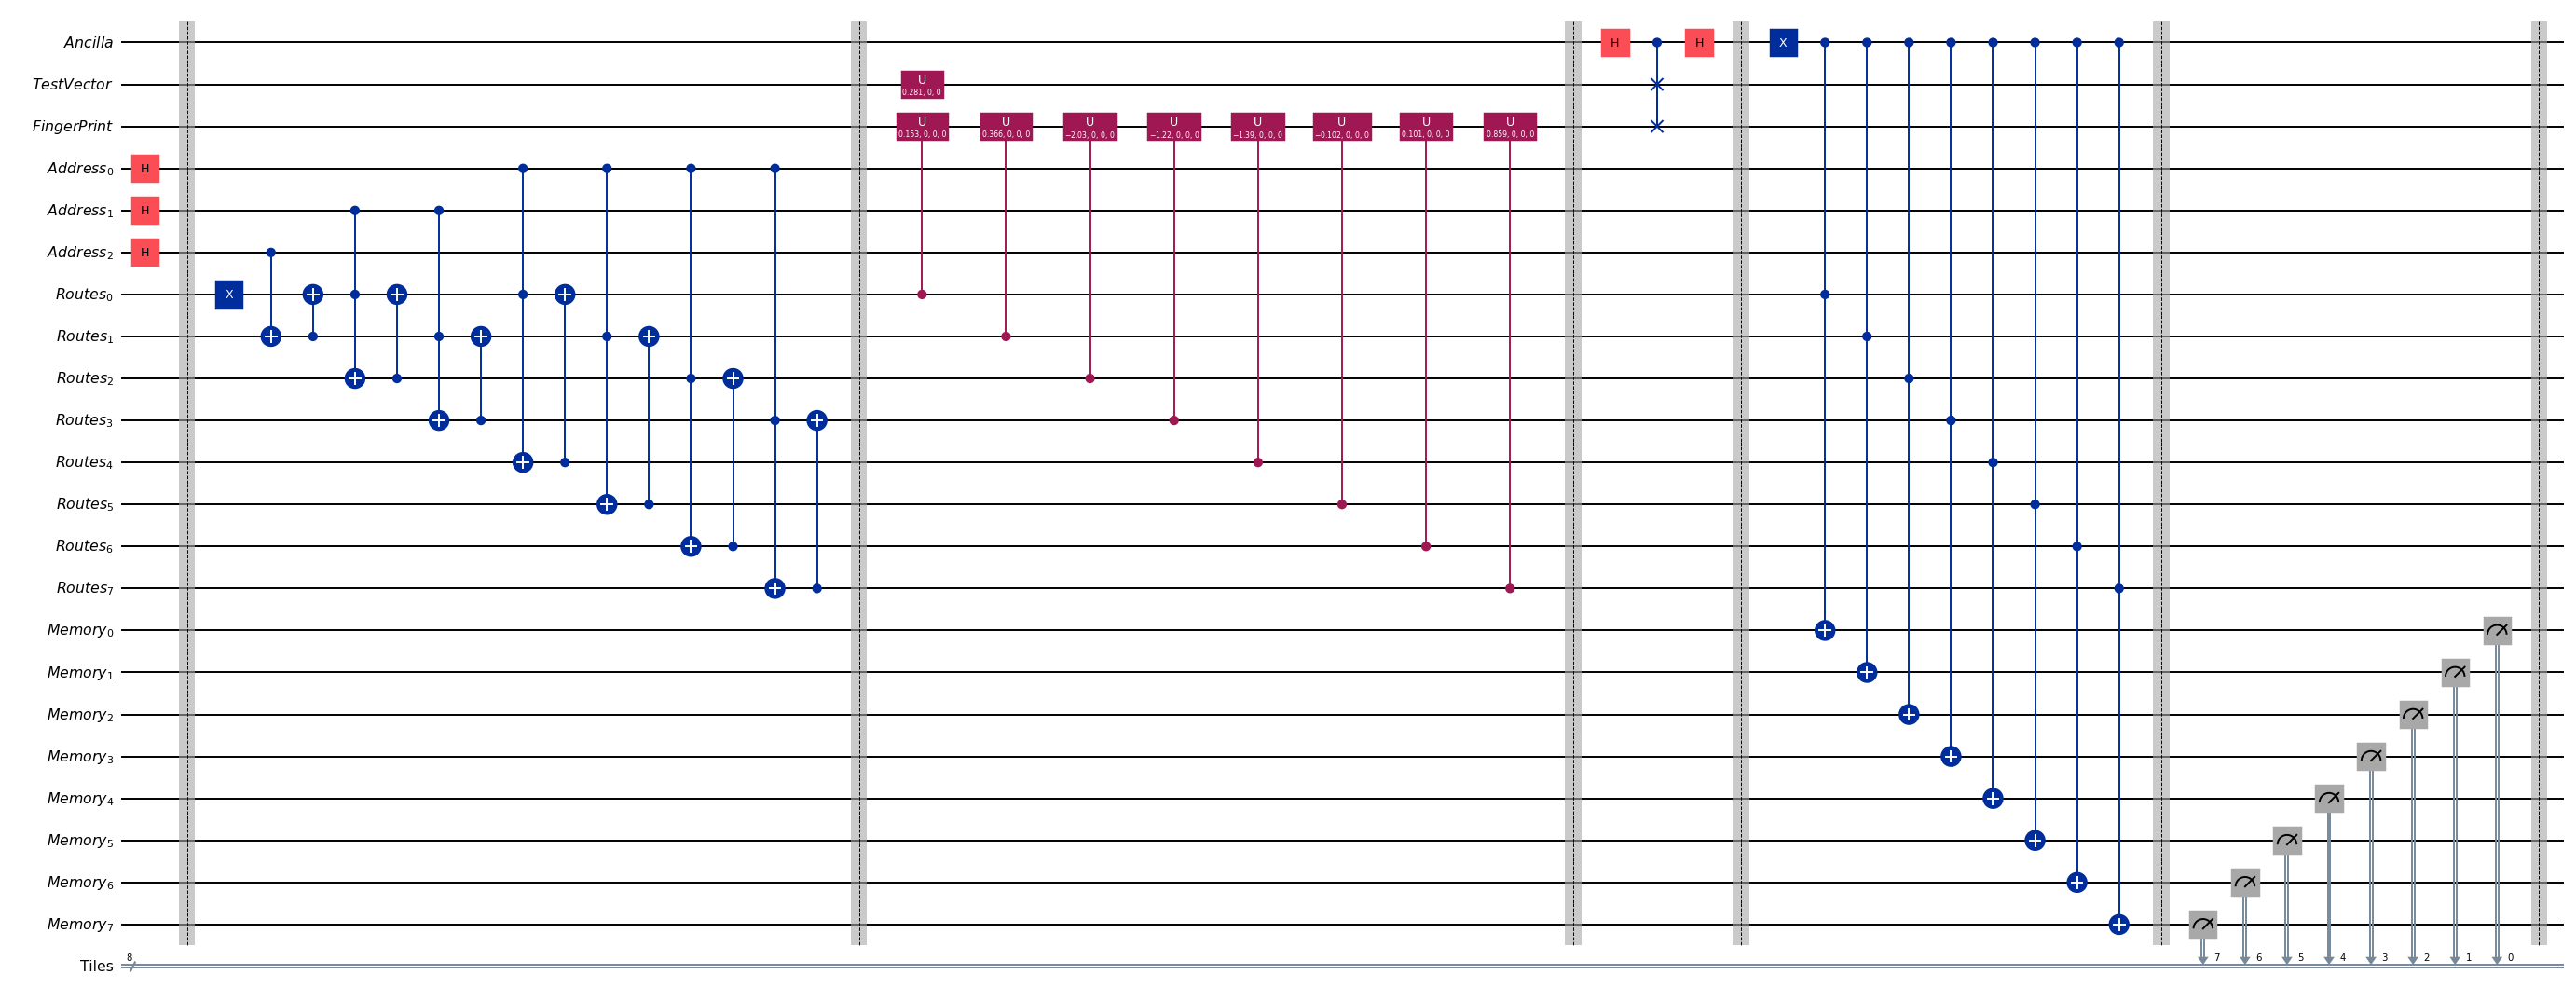

In [13]:
if not compiled_circuit is None:
    display( circuit_drawer( compiled_circuit.reverse_bits() , output='mpl' , scale=0.7 , fold=-1) )

In [14]:
address_mapping = {
                        '10000000' : 'Q1',
                        '01000000' : 'Q2',
                        '00100000' : 'Q3',
                        '00010000' : 'Q4',
                        '00001000' : 'Q5',
                        '00000100' : 'Q6',
                        '00000010' : 'Q7',
                        '00000001' : 'Q8',
                  }

### Run quantum algorithm on local AER simulator (no noise)

In [15]:
job   = None
if not compiled_circuit is None:

    _start     = monotonic()
    _startTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
    print("Started at {}".format(_startTime) )
    ##############################################################################
    job = aer.run( compiled_circuit , shots=shots ).result()
    ##############################################################################
    _endTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
    _end     = monotonic()
    print("Started at ", _startTime, ", ended at ", _endTime, ", total elapsed ", round((_end-_start),1), " seconds")

    sum = 0
    noises             = {}
    binary_frequencies = {}

    if not job is None:
        print( job.job_id )
        results = job.get_counts(0)
        for result in results:
            if result in address_mapping:
                binary_frequencies[ address_mapping[result] ] = results[result]
            else:
                noises[ result ] = results[result]

Started at 08-July-2024 13:58:03.827609
Started at  08-July-2024 13:58:03.827609 , ended at  08-July-2024 13:58:04.530335 , total elapsed  0.7  seconds
5403c1d4-3abf-4346-b784-4be9e09fea6e


{'Q5': 786, 'Q6': 1108, 'Q7': 1094, 'Q1': 1120, 'Q8': 1102, 'Q4': 890, 'Q2': 1104, 'Q3': 608}


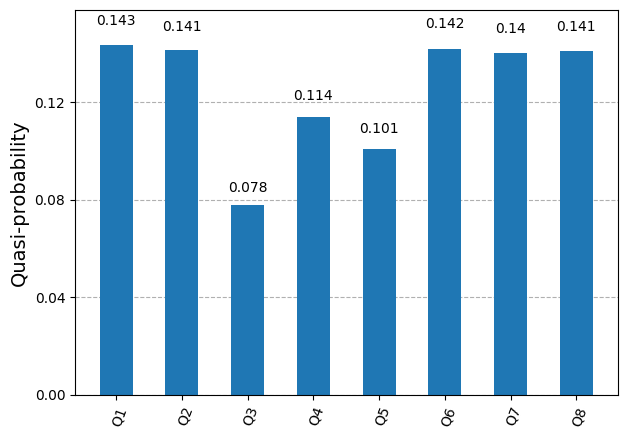

In [16]:
print( binary_frequencies )
display( plot_distribution( binary_frequencies ) )

{'00000000': 1076}


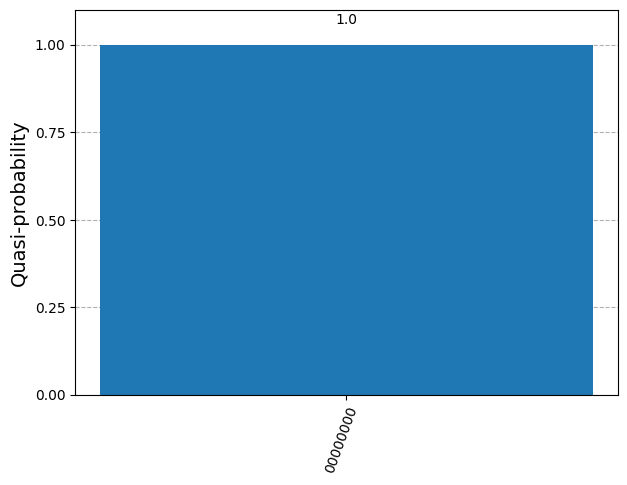

In [17]:
print( noises )
display( plot_distribution( noises ) )

In [18]:
qc.num_qubits

22

### Result from quantum algorithm on real quantum computer at IBM Quantum Platform (10 mins cap per month / open plan)

In [ ]:
# job = service.job('cspkxqpp1vzg008aena0')
# job_result = job.result()

In [ ]:
# json_results = job_result.quasi_dists[0].binary_probabilities()
# json_results

In [ ]:
# expected_regions = []
# expected_values  = []
# noisy_regions    = []
# noisy_values     = []
# for _result in json_results:
#     if _result in address_mapping:
#         expected_regions.append( address_mapping[_result] )
#         expected_values.append( json_results[_result] )
#     else:
#         noisy_regions.append( _result )
#         noisy_values.append( json_results[_result] )

In [ ]:
# fig = plt.figure(figsize=(5, 5))
# plt.barh( expected_regions , expected_values, color='g' )
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(5, 40))
# plt.barh( noisy_regions    , noisy_values,    color='r' )
# plt.barh( expected_regions , expected_values, color='g' )
# plt.show()

### Run quantum algorithm on local backend "ibm_brisbane" simulator (with simulated noise)

In [ ]:
# https://docs.quantum.ibm.com/verify/local-testing-mode
# shots = 8888
# try:
#     # sim_backend = FakeBrisbane()
#     # sim_backend = FakeKyoto()
#     # sim_backend = FakeOsaka()
#     sim_backend  = AerSimulator.from_backend(real_backend)

#     sim_pass_manager = generate_preset_pass_manager( backend=sim_backend, optimization_level=1 )
#     sim_circ         = sim_pass_manager.run( qc )

#     _start     = monotonic()
#     _startTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
#     print("Started at {}".format(_startTime) )
#     ##############################################################################
#     options          = {"simulator": {"seed_simulator": 42}}
#     local_simulator  = SamplerV2( sim_backend, options=options )
#     simulator_result = local_simulator.run( [sim_circ] ).result()
#     ##############################################################################
#     _endTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
#     _end     = monotonic()
    
#     print("Started at ", _startTime, ", ended at ", _endTime, ", total elapsed ", round((_end-_start),1), " seconds")
#     sim_result_plot = simulator_result.quasi_dists[0].binary_probabilities()
#     print( sim_result_plot )

# except Exception as err:
#     print(err)

In [ ]:
# noises             = {}
# binary_frequencies = {}

# for result in sim_result_plot:
#     if result in address_mapping:
#         binary_frequencies[ address_mapping[result] ] = sim_result_plot[result]
#     else:
#         noises[ result ] = sim_result_plot[result]

In [ ]:
# print( binary_frequencies )
# display( plot_distribution( binary_frequencies ) )

In [ ]:
# print( noises )
# display( plot_distribution( noises ) )

## Run quantum algorithm on actual IBM Quantum device (ibm_brisbane)

In [ ]:
actual_quantum_device_results = None
shots = 8888
# try:
#     _start     = monotonic()
#     _startTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
#     ##############################################################################
#     transpiled_circuit = real_pass_manager.run( qc )
#     actual_quantum_device_results = SamplerV2( real_backend ).run( [transpiled_circuit] , shots=shots ).result()
#     ##############################################################################
#     _endTime = datetime.now().strftime("%d-%B-%Y %H:%M:%S.%f")
#     _end     = monotonic()
#     print("Started at ", _startTime, ", ended at ", _endTime, ", total elapsed ", round((_end-_start),1), " seconds")

# except Exception as err:
#     print("Exception : ", err)

In [ ]:
# if not actual_quantum_device_results is None:
#     result_plot = plot_distribution( actual_quantum_device_results.quasi_dists[0] )
#     display( result_plot )

In [ ]:
# results_with_noise = None
# if not actual_quantum_device_results is None:
#     results_with_noise =  actual_quantum_device_results.quasi_dists[0].binary_probabilities()
#     print( results_with_noise )

In [ ]:
# expected = {}
# noises   = {}
# if not results_with_noise is None:
#     for result in results_with_noise:
#         if result in address_mapping:
#             expected[ address_mapping[result] ] = results_with_noise[result]
#         else:
#             noises[ result ] = results_with_noise[result]

In [ ]:
# if len(expected) > 0:
#     print( "Actual region is", actual_region )
#     print("Displaying probability distribution after removing noises...")
#     result_plot = plot_distribution( expected )
#     display( result_plot )

In [ ]:
# if len(noises) > 0:
#     noise_plot = plot_distribution( noises )
#     display( noise_plot )